In [4]:
from pathlib import Path
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

2023-09-08 11:34:44.347988: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-08 11:34:44.349629: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-08 11:34:44.383287: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-08 11:34:44.384163: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 11:34:45.182459: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [5]:
# define paths
base_path = Path("raw_data/photos/")

# Image folders paths
img_val_path = base_path.joinpath("movies_val_resized")
img_train_path = base_path.joinpath("movies_train")

# csv files
df_big = pd.read_csv("movies_big_year_genre.csv")
df_train = pd.read_csv("movies_train_year_genre.csv")

# autoencoder path 
models_path = Path("raw_data/models") 

# Current df and working folder
IMAGES_PATH = img_val_path # contains atm 25_000 images
IMAGE_WIDTH = 352
IMAGE_HEIGHT = 528

In [6]:
autoencoder = models.load_model(models_path.joinpath('autoencoder'))

In [7]:
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 30)                10737918  
                                                                 
 decoder (Sequential)        (None, 528, 352, 3)       363451    
                                                                 
Total params: 11101369 (42.35 MB)
Trainable params: 11101369 (42.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
encoder = autoencoder.get_layer('encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 526, 350, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 263, 175, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 261, 173, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 130, 86, 32)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 357760)            0         
                                                                 
 dense_4 (Dense)             (None, 30)                1073

In [9]:
def build_encoding_dataset(images_path=IMAGES_PATH,
                               width=IMAGE_WIDTH, height=IMAGE_HEIGHT,
                               batch_size=32):

    return image_dataset_from_directory(
        images_path,
        labels=None,
        label_mode=None,
        batch_size=batch_size,
        image_size=(height, width),
        shuffle=False,
        seed=42,
    ).map(
        lambda x: x / 255.0
    )

dataset_encoding = build_encoding_dataset()


Found 750 files belonging to 1 classes.


In [ ]:
i = iter(dataset_encoding)
n = next(i)
type(n)

In [ ]:
embeddings = encoder.predict(dataset_encoding)

In [ ]:
X = embeddings
y_year = df_big.sort_values("imdbID").Year.values
y_genre = df_big.sort_values("imdbID")[['Family', 'Action', 'Comedy', 'Thriller', 'Romance', 'Crime', 'Sci-Fi', 'Drama']].values

In [ ]:
from sklearn.model_selection import train_test_split

Xy_train, Xy_test, yy_train, yy_test = train_test_split(X, y_year, test_size=.1, shuffle=True)

Xy_train.shape, Xy_test.shape, yy_train.shape, yy_test.shape

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn_years = KNeighborsRegressor(n_neighbors=10)
knn_years.fit(Xy_train, yy_train)

In [ ]:
yy_pred = knn_years.predict(Xy_test)

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(yy_test, yy_pred)

* Genre

In [ ]:
Xg_train, Xg_test, yg_train, yg_test = train_test_split(X, y_genre, test_size=.1, shuffle=True)

Xg_train.shape, Xg_test.shape, yg_train.shape, yg_test.shape

In [ ]:
from sklearn.neighbors import NearestNeighbors

knn_genres = NearestNeighbors(n_neighbors=10)
knn_genres.fit(Xg_train, yg_train)

In [ ]:
import pickle 

# Save KNN genre file
# Its important to use binary mode 
knn_genre_pickle = open(models_path / 'knnpickle_genre', 'wb') 
# source, destination 
pickle.dump(knn_genres, knn_genre_pickle) 
# close the file
knn_genre_pickle.close()

# Save yg_train, needed for KNN
np.save(models_path / "genre_predict.npy", yg_train)

In [13]:
def predict_year(new_X, knn):
  X = new_X if new_X.ndim == 2 else new_X.reshape(1, -1) # if it's a single obs, reshape to fit sklearn model
  return knn.predict(X)

In [7]:
GENRES = [
  'Family',
  'Action',
  'Comedy',
  'Thriller',
  'Romance',
  'Crime',
  'Sci-Fi',
  'Drama'
]

def get_genres(indices):
  return [GENRES[i] for i in indices]

def build_multihot(indices, size=8):
  a = np.zeros((8,))
  a[indices] = 1
  return a

def predict_genres(new_X, n_genres, knn, y_genres_ref):
  X = new_X if new_X.ndim == 2 else new_X.reshape(1, -1) # if it's a single obs, reshape to fit sklearn model

  _, indices = knn.kneighbors(X)

  # given their indices, goes grabbing them
  neighbors_labels = y_genres_ref[indices] # axis 0, 1, 2: 0->each tested poster; 1->its neighbors; 2->genres

  # for each tested poster, the sum of genres of its neighbors
  neighbors_added_genres = neighbors_labels.sum(axis=1)


  genres_indices = np.argpartition(neighbors_added_genres, -n_genres)[:, -n_genres:]

  return genres_indices

In [9]:
import pickle 

loaded_model_year = pickle.load(open(models_path / 'knnpickle_years', 'rb'))
#print(predict_year(Xy_test[2], loaded_model_year))

loaded_model_genre = pickle.load(open(models_path / 'knnpickle_genre', 'rb'))
#print(predict_genres(Xg_test[2], 2, loaded_model_genre, yg_train))

y_genres_ref = np.load(models_path / 'genre_predict.npy', 'rb')
#print(predict_genres(Xg_test[2], 2, loaded_model_genre, yg_train))

/home/jamie/.pyenv/versions/3.10.6/envs/movie/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsRegressor from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


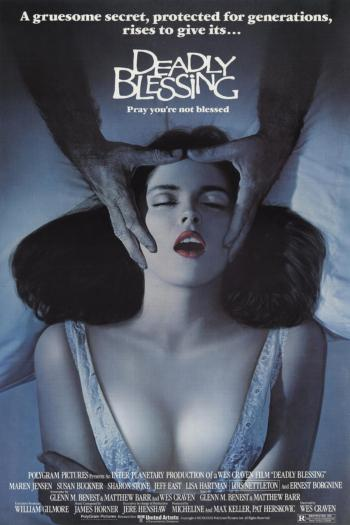

In [10]:
from PIL import Image

images = os.listdir(IMAGES_PATH)[:10]
im = Image.open(IMAGES_PATH.joinpath(images[8]))
im

In [14]:
def embed_images(im):
    img_np = np.expand_dims(im, axis=0)
    img_np = img_np.astype('float32') / 255.0
    img_tf = tf.convert_to_tensor(img_np)
    img_resized = tf.image.resize(img_tf, (528, 352))
    image_embeddings = encoder.predict(img_resized)
    img_emb = image_embeddings[0]
    return img_emb

img_emb = embed_images(im)

1/1 [==============================] - 0s 32ms/step


In [ ]:
predict_year (img_emb, loaded_model_year)

predict_genres(img_emb, 2, loaded_model_genre, y_genres_ref)